In [1]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from os.path import join as oj
import sys
sys.path.append('../vision_fit')
sys.path.append('../vision_analyze')
import data
import numpy as np
from copy import deepcopy
import pickle as pkl
from torch.optim.lr_scheduler import StepLR
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
import models
from dim_reduction import *
import viz_weights
import siamese

%load_ext autoreload
%autoreload 2
%matplotlib inline

# load some models             
convnet = models.LeNet()
linnet = models.LinearNet(4, 28*28, 256, 10)
model = linnet
model = model.cuda()

# load mnist
from params_vision import p
p.dset = 'mnist'
p.shuffle_labels = False
train_loader, test_loader = data.get_data_loaders(p)

In [2]:
# deal with reps
linnet = models.LinearNet(4, 28*28, 256, 10).cuda()
lenet = models.LeNet().cuda()

In [55]:
root = oj('/scratch/users/vision/yu_dl/raaz.rsk/data/mnist')
rng = np.random.RandomState(92916)
idx_permute = torch.LongTensor(rng.permutation(784))

trans = transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize((0.5,), (1.0,)),
#                             transforms.Lambda(lambda x: x.view(-1)[idx_permute].view(1, 28, 28))
                            ])

train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=32,
                 shuffle=False)

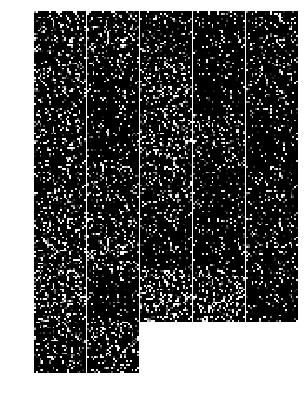

In [56]:
batch = next(iter(train_loader))
ims = batch[0].detach().numpy().squeeze()
viz_weights.plot_weights(ims)
# plt.imshow(ims[0, 0])

# get the full dsets

In [40]:
# X_train, Y_train, X_test, Y_test = data.process_loaders(train_loader, test_loader)
X_train, Y_train_onehot = data.get_XY(train_loader)

# siamese net

In [97]:
model = siamese.SiameseNet(lenet, X_train, Y_train_onehot, 
                           reps=2, similarity='dot', siamese_init='unif', 
                           train_prototypes=True, prototype_dim=14).cuda()
x = torch.Tensor(X_train[0:2]).cuda()
y = model(x)

# data-driven init

In [8]:
from vision_fit.init import *

# final layer only
# initializes final ws = xs (with appropriate class)
# intializes bs = 0 
# X should have atleast as many examples as there are weights in any layer
def initialize_ws_and_zero_bias_lay_final(X, Y_train_onehot, model):
    print('init final lay ws')
    
    # pick the examples on the first iteration
    # get prototype images for each label (reps is how many repeats)
    # returns images (X) and labels (Y)
    def get_ims_per_lab(X_train, Y_train_onehot, reps=1):
        exs = np.zeros((10 * reps, X_train.shape[1]))
        labs = np.zeros(10 * reps)
        for i in range(10):
            idxs = Y_train_onehot[:, i] == 1
            exs[reps * i: reps * (i + 1)] = X_train[idxs][:reps]
            labs[reps * i: reps * (i + 1)] = i
        return exs, labs

    exs, _ = get_ims_per_lab(X_train, Y_train_onehot, p.reps)
    
    if torch.cuda.is_available():
        exs = torch.Tensor(exs).cuda()
    else:
        exs = torch.Tensor(exs)
    
        
    acts = model.features(exs)
    # preserve model layer norm
    model.last_lay().weight.data = acts / acts.norm() * model.last_lay().weight.data.norm()


initialize_ws_and_zero_bias_lay_final(X_train, Y_train_onehot, model)

init final lay ws


In [9]:
exs, _ = get_ims_per_lab(X_train, Y_train_onehot, p.reps)

In [10]:
exs2 = np.mean(exs, axis=0).reshape(1, -1)
print(exs2.shape)

(1, 784)


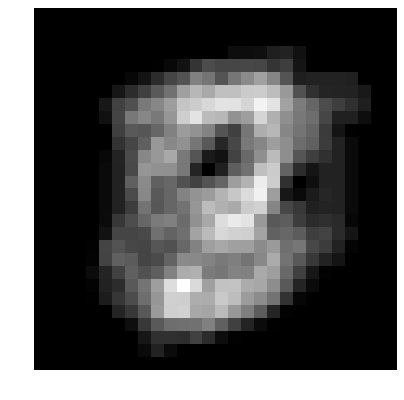

In [11]:
viz_weights.plot_weights(exs2)